# Module 6 Lab 1 - Logistic regresson to predict readmission

In this lab, we will introduce the dataset we will use, and perform a basic logistic regression to predict the probability of within-30-days readmission to a hospital.  Hospitals strive to minimize this because the Centers for Medicare and Medicaid Services (CMS) may penalize them for having a readmission rate that is too high.

The dataset we are using is focused on diabetes, and whether proper management of blood sugar levels while in the hospital have an impact on readmission.  We are losely following the model developed in the associated publication [Impact of HbA1c Measurement on Hospital Readmission Rates:Analysis of 70,000 Clinical Database Patient Records](../resources/Impact-of-HbA1c-Measurement-on-Hospital-Readmission-Rates-Analysis-of-70000-Clinical-Database-Patient-Records.pdf), but we are not creating interaction terms.  This dataset has already been prepared for use in machine learning following most of the data preprocessing steps described in the paper. 

The prepared dataset contains the following fields:

* readmitted            
    * 1 = readmission within 30 days of discharge
    * 0 = no readmission within 30 days
* discharge             
    * 0 = discharged to home
    * 1 = discharged elsewhere
* age                   
    * 0 = 30-59
    * 1 = 0-30
    * 2 = >= 60
* race                  
    * 0 = African American
    * 1 = Caucasian
    * 2 = Unknown
    * 3 = Other
* admission_type        
    * 0 = Emergency
    * 1 = Referral
    * 2 = Other
* specialty -              specialty of admission department
     * 0 = Cardiology
     * 1 = Family/General Practice
     * 2 = Internal Medicine
     * 3 = Unknown
     * 4 = Surgery
     * 5 = Other
* time_in_hospital -       number of days in hospital
* diag_1 -                 primary diagnosis: 
    * 0 = “diabetes” for icd9: 250.xx
    * 1 = “circulatory”for icd9: 390–459, 785 
    * 2 = “digestive” for icd9: 520–579, 787
    * 3 = “genitourinary”for icd9: 580–629, 788 
    * 4 = “injury” for icd9: 800–999
    * 5 = “musculoskeletal” for icd9: 710–739 
    * 6 = “neoplasms” for icd9: 140–239
    * 7 = “respiratory” for icd9: 460–519, 786
    * 8 = “other”
* A1Cresult -              result of last HbA1C test
    * 0 = No test performed
    * 1 = Normal
    * 2 = result > 7
    * 3 = result > 8
* change -                 diabetes medication adjusted while in hospital? 0 = no, 1 = yes


We will perform a standard logistic regression to use as a base line for comparing other machine learning approaches.  Logistic regression has some assumptions that must be met in order for the resulting model to be valid.  In this case we will not test those as we wish to simply compare the accuracy and AUC with other approaches, which are not bound by the same set of assumptions.

In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [3]:
data = pd.read_csv('../resources/diabetes_readmission.csv')
display(data.head())

print(data.dtypes)



,readmitted,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,1,0,0,1,1,0,8,8,0,1
1,0,0,0,1,1,4,2,8,0,0
2,0,1,2,1,1,2,4,8,2,0
3,0,0,2,1,1,2,3,8,3,1
4,0,0,0,0,1,2,5,8,0,0


readmitted          int64
discharge           int64
age                 int64
race                int64
admission_type      int64
specialty           int64
time_in_hospital    int64
diag_1              int64
A1Cresult           int64
change              int64
dtype: object


## Preprocessing

We will first split the data into the dependent variable and independent variables.


In [4]:
y = data['readmitted']
X = data[['discharge', 'age', 'race', 'admission_type', 'specialty', 'time_in_hospital', 'diag_1', 'A1Cresult', 'change']]

display(X)

,discharge,age,race,admission_type,specialty,time_in_hospital,diag_1,A1Cresult,change
0,0,0,1,1,0,8,8,0,1
1,0,0,1,1,4,2,8,0,0
2,1,2,1,1,2,4,8,2,0
3,0,2,1,1,2,3,8,3,1
4,0,0,0,1,2,5,8,0,0
...,...,...,...,...,...,...,...,...,...
65953,0,2,1,1,3,1,8,0,0
65954,0,2,3,1,2,3,8,0,0
65955,0,2,1,1,3,3,8,0,1
65956,1,0,1,1,3,14,8,2,1


## Scale the continuous feature
We should scale the one continuous feature in the dataset.  Scaling will give us a feature that has mean zero and standard deviation 1.  Some of the methods we will use are more sensitive to differences in feature scaling than others.  It's not strictly necessary for logistic regression to create a good model, but we will do it for the sake of consistency.  

We have only one continuous feature, and the remainder are one-hot-encoded categorical features.

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X['time_in_hospital'] = scaler.fit_transform(X[['time_in_hospital']])

/opt/conda/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### Categorize our independent variables

Our independent variables are mostly categoricals, so we need to encode any that aren't dichotomous for use in regression, using a k-1 one-hot-encoding scheme.

In k-1, we first perform a one-hot, but then drop one of the generated features.  This is necessary for logistic regression to avoid multicolinearity, as the absence of 1's in k-1 of the features implies the presence of 1 in the k<sup>th</sup> feature.

In [6]:
# create dummy variables
X = pd.concat([X, pd.get_dummies(X['age'], prefix = 'age', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['race'], prefix = 'race', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['admission_type'], prefix = 'admission_type', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['specialty'], prefix = 'specialty', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['diag_1'], prefix = 'diag_1', drop_first=True)], axis=1)
X = pd.concat([X, pd.get_dummies(X['A1Cresult'], prefix = 'A1Cresult', drop_first=True)], axis=1)

# drop originals
X = X.drop(['age', 'race', 'admission_type', 'specialty', 'diag_1', 'A1Cresult'], axis=1)



## Create balanced classes by oversampling the minority class

Some of the methods we will use in this module are very sensitive to unbalanced classes, including logistic regression, so we will balance our classes by sampling with replacement from the smaller class until the classes are equal in size.

Scikit learn provides the resample utility for this, which makes the process very simple.

In [7]:
from sklearn.utils import resample

display(y.value_counts())

X_oversampled, y_oversampled = resample(X[y == 1], y[y == 1], replace=True, n_samples=X[y == 0].shape[0], random_state=42)

X = pd.DataFrame(np.vstack((X[y == 0], X_oversampled)), columns=X.columns)
y = np.hstack((y[y == 0], y_oversampled))

display(pd.Series(y).value_counts())

0    60145
1     5813
Name: readmitted, dtype: int64

1    60145
0    60145
dtype: int64

## Fit the regression

Here we will fit the regression.  We are using the liblinear solver because it is able to handle the dataset that we have.  We use a train test split of 67/33.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# train/test split, specify the seed for reproducible results
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


model = LogisticRegression(solver='liblinear').fit(X_train, y_train)



## Visualize the results
We will print the accuracy, an ROC plot along with the AUC, a confusion matrix, and a classification report.

We will use these same outputs in the following labs to see the differences.

accuracy 0.5793278919790407


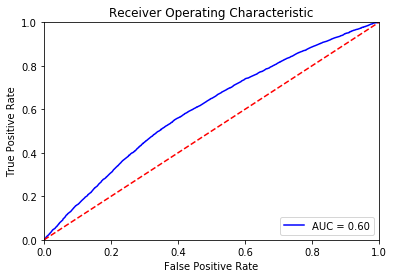

confusion matrix:
[[12981  6968]
 [ 9731 10016]]

classification report:
              precision    recall  f1-score   support

           0       0.57      0.65      0.61     19949
           1       0.59      0.51      0.55     19747

   micro avg       0.58      0.58      0.58     39696
   macro avg       0.58      0.58      0.58     39696
weighted avg       0.58      0.58      0.58     39696



In [9]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

print('accuracy', model.score(X_test, y_test))

probs = model.predict_proba(X_test)
preds = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_pred = model.predict(X_test)

cmatrix = confusion_matrix(y_test, y_pred)
print('confusion matrix:')
print(cmatrix)
print('\nclassification report:')
print(classification_report(y_test, y_pred))

## Visualize the regression
We will print out the regression formula here.  The ability to see a formula, and interpret the relative strengths of the various associations between the independent variables is one of the main reasons that regressions are so explainable.

In the case of a logistic regression, the result of the formula is the log odds $ln(\frac{p} {(1-p)})$, which can be converted to a probability using the final derived formula:

<img src='../resources/logit-to-probability.png'/>
 

In [10]:
'y = ' + ' + '.join([f'{round(b, 3)}*{x}' for x, b in zip(X_train.columns, model.coef_[0])]) + f' + {round(model.intercept_[0], 3)}'

'y = 0.561*discharge + 0.098*time_in_hospital + 0.073*change + -0.116*age_1 + 0.202*age_2 + 0.007*race_1 + -0.282*race_2 + -0.16*race_3 + 1.035*admission_type_1 + 1.051*admission_type_2 + 0.202*specialty_1 + 0.229*specialty_2 + 0.142*specialty_3 + -0.029*specialty_4 + -0.02*specialty_5 + -0.077*A1Cresult_1 + -0.067*A1Cresult_2 + -0.071*A1Cresult_3 + -1.524'